In [9]:
import MulensModel as mm
import numpy as np
import os
import matplotlib.pyplot as plt
from param_utils import Param, Params
from astropy.io import ascii
import torch
import scipy

In [10]:
def get_curve(args):
    my_1S2L_model = mm.Model({'t_0': 0, 'u_0': args[0],
                              't_E': args[1], 'rho': args[2], 'q': args[3], 's': args[4],
                              'alpha': args[5]})
    times = my_1S2L_model.set_times()
    times -= min(times)
    lc = my_1S2L_model.get_lc(source_flux=1)
    return times, lc

In [11]:
def choose_random_noise_curve(chunk_size=225, outlier_cutoff=3):
    fdir = "data/lightcurves/"
    directory = os.fsencode(fdir)
    files = os.listdir(directory)

    def grab_curve():
        # choose a random light curve
        selection_index = np.random.choice(len(files), replace=False) 
        curve = ascii.read(fdir + os.fsdecode(files[selection_index]), format='ipac')
        
        # grab all real values
        unmasked_inds = curve['cor_flux'].data.nonzero()

        # check there are real values
        if len(unmasked_inds[0]) == 0:
            return grab_curve()
    
        # first real index
        start = unmasked_inds[0][0]
        
        # fill x range to interpolate over
        x_filled = np.arange(curve['HJD'][start], curve['HJD'][start] + chunk_size)

        # grab real data + interpolate + return
        unmasked = curve['cor_flux'].data[unmasked_inds]
        unmasked_time = curve['HJD'][unmasked_inds]
        sample_interpolated = np.interp(x_filled, unmasked_time, unmasked)

        x_filled = x_filled - curve['HJD'][start]
        return x_filled, sample_interpolated

    x_i, y_i = grab_curve()

    # we check for variance with a moving average (faster than FFT methods)
    def moving_average(a, n=20):
        # n = 10 to capture large events (microlensing events) without filtering out noise
        ret = np.cumsum(a, dtype=float)
        ret[n:] = ret[n:] - ret[:-n]
        return ret[n - 1:] / n

    moving_avg = moving_average(y_i)
    curve_variance = max(moving_avg)
    max_variance = outlier_cutoff * np.std(y_i)
    
    if curve_variance > max_variance:
        #print("outliers in our noise curve, grabbing new data")
        x_i, y_i = grab_curve()

    return x_i, y_i

def noisy_curve(args):
    x, y = get_curve(args)
    noise_x, noise_y = choose_random_noise_curve()
    domain_shift = (max(x) - min(x)) / (max(noise_x) - min(noise_x))
    noise_interp = np.interp(x, noise_x * domain_shift, noise_y)
    noise_small = noise_interp * 3 * np.std(y) / (max(noise_interp) - min(noise_interp))
    curve = y + noise_small
    return x, curve

In [12]:
def fitcurve(x_t, y_t):
    params = Params()
    vals_0, labels = params.get_val() # generates random values...
    
    def error_function(args):
        nonlocal x_t
        nonlocal y_t
        
        x_p, y_p = get_curve(args)

        y_p = np.interp(x_t, x_p, y_p)
        x_p = x_t

        pred = torch.tensor(np.stack([x_p, y_p], axis=-1), dtype=torch.float32)
        true = torch.tensor(np.stack([x_t, y_t], axis=-1), dtype=torch.float32)
        return (y_p - y_t).flatten()
    # True Params: ['u_0: 0.61', 't_E: 5.85', 'rho: 0.03', 'q: 0.10', 's: 0.25', 'alpha: 22.25']

    lower_bound = [params.u_0.min, params.t_E.min, params.rho.min, params.q.min, params.s.min, params.alpha.min]
    upper_bound = [params.u_0.max, params.t_E.max, params.rho.max, params.q.max, params.s.max, params.alpha.max]
    bounds = (lower_bound, upper_bound)
    result = scipy.optimize.least_squares(error_function, vals_0,bounds=bounds)
        
    return result

In [17]:
params = Params()
vals, labels = params.get_val() # generates random values...
x, y = noisy_curve(vals)
print("True Params:", labels)
p = fitcurve(x, y)
print("Guessed:", p)

True Params: ['u_0: 0.68', 't_E: 50.00', 'rho: 0.01', 'q: 0.01', 's: 0.43', 'alpha: 3.40']
Guessed:      message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 1.106e-02  9.570e-03 ... -1.857e-02 -2.073e-02]
           x: [ 6.710e-01  4.397e+01  6.529e-02  1.662e-01  6.141e-01
                2.707e+01]
        cost: 1.1914954306233552
         jac: [[ 6.743e-02  0.000e+00 ... -3.773e-03  1.768e-05]
               [ 6.796e-02  1.191e-05 ... -3.847e-03  1.756e-05]
               ...
               [ 1.308e-01 -1.084e-07 ...  3.593e-01  4.045e-05]
               [ 1.308e-01 -1.084e-07 ...  3.593e-01  4.045e-05]]
        grad: [ 3.513e+00 -2.470e-01  0.000e+00 -2.079e+00  1.549e+00
                2.334e-02]
  optimality: 2.3570437437052845
 active_mask: [0 0 0 0 0 0]
        nfev: 19
        njev: 15


['u_0: 0.68', 't_E: 50.00', 'rho: 0.01', 'q: 0.01', 's: 0.43', 'alpha: 3.40']


/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/model.py:267: UserWarning: No blend_flux not specified. Assuming blend_flux = zero.
  warnings.warn(
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/magnificationcurve.py:195: UserWarning: A finite source parameter (rho or t_star) is set and no finite-source method is set.
For possible magnification methods see
/home/skelly/school/exoplanets/microlensing/env/lib/python3.12/site-packages/MulensModel/documents/magnification_methods.pdf
or
https://github.com/rpoleski/MulensModel/blob/master/documents/magnification_methods.pdf
  warnings.warn(msg, UserWarning)


Text(0.5, 0, 'Time')

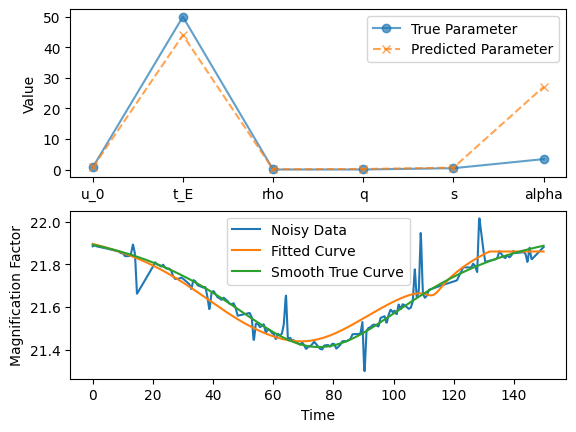

In [19]:

arg_names = ['u_0', 't_E', 'rho', 'q', 's', 'alpha']
fig, (ax1, ax2) = plt.subplots(2)
print(labels)
ax1.plot(np.arange(6), vals, 'o-', label='True Parameter', alpha=0.7)
ax1.plot(np.arange(6), p["x"], 'x--', label='Predicted Parameter', alpha=0.7)
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(arg_names)
ax1.set_ylabel("Value")
ax1.legend()

ax2.plot(x, y, label="Noisy Data")
x_fit, y_fit = get_curve(p["x"])
x_true_fit, y_true_fit = get_curve(vals)
y_fit = np.interp(x, x_fit, y_fit)
y_true_fit = np.interp(x, x_true_fit, y_true_fit)
ax2.plot(x, y_fit, label="Fitted Curve")
ax2.plot(x, y_true_fit, label="Smooth True Curve")
ax2.legend()
ax2.set_ylabel("Magnification Factor")
ax2.set_xlabel("Time")